In [9]:
import sys
import os.path
sys.path.append(os.path.join('.', 'util'))

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

from timer import Timer

import pylab as plt
import numpy as np

# Bilateral filter

Theory from [this paper](http://people.csail.mit.edu/sparis/publi/2009/fntcgv/Paris_09_Bilateral_filtering.pdf)

**Why not on GPU?**

This project seem to fit better GPU calculation. However, developping on CPU permits to use the memory hierarchy more than using GPU. Indeed the cache is bigger in the CPU which permits to get more context for a pixel in cache.  

As seen in this image from the class (credit Ray Thouis Jones): 

![credit Ray Thouis Jones](cacheCPUvsGPU.png)

Using the SIMD of AVX allows us to optimize performance on CPU calculation. However, this will be true only if the algorithm is **computation bound** and not **memory bound**. That is why we will pay special care to memory optimization in this project.


# Code implementations and optimization

## Introductory remarks

In the following part of the report we will introduce snippets of our code that don't run by themselves but that show the different things we tried to get better performances. All the function are written in seperate files and are called within this Ipython notebook. We will also consider performances.

Another remarks concerning the content of this report. We emphasized our work on the optimization of the code, the understanding of different concepts such as the memory behavious and the parallelism. We explore some implementations using AVX. However, we could not manage to code the exponential function in AVX. My computer has only SSE and has an AVX emulator. There are exp functions coded for AVX on the internet but they are not working with my emulator. As finding a hack to make work was starting to take too much of our time, we decided to move on in order to focus on concepts of the course and simply commenting out the lines where we take the exp of an AVX array. We could still benchmarck the accuracy of our code when we were not using AVX, in a first step with the Gaussian filter that we compared against a scipy function and for a bilateral filter using only cython. We have already showed an output image of our code as the example for the bilateral filter at the beginning of this report (where we used the function r_r1 that we present below).

---

---

## Cython, AVX and Python multithreading

### Cython

You can see the documentation [here](http://docs.cython.org/). We specifically use:

- the fact that we can release the Global Interpreter Lock (GIL) with Cython. It will prove particularly useful in our multi-threaded implementation because it permits actual multi-threading.
- the cython implementation of OpenMP for parallelism, and more specifically [prange](http://docs.cython.org/src/userguide/parallelism.html). We will just remind that at the end of every  prange(),there is an implicit barrier. All threads must reach the barrier before computation continues, and there is no locks.

Nota Bene: my computer having only 2 threads, when there is a prange, the number of threads working is equal to 2. The description of this machine is in the following cell:

In [99]:
%watermark

2016-02-05T19:29:57

CPython 2.7.6
IPython 3.1.0

compiler   : GCC 4.8.2
system     : Linux
release    : 3.13.0-77-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


### AVX

Advanced Vector Extensions (AVX) are extensions to the x86 instruction set architecture for microprocessors from Intel and AMD (from [Wikipedia](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)). My computer actually uses another extension which SS3 (because it was built before 2011).

**More's law**

As seen in class, the number of transistors per chip has increased following More's exponential law. Though the clock time has not (transistors get smaller but heat cannot be sucked out of the chips fast enough for a given area, thus the temperature increases and the chip melts). AVX uses the paradigm of **[SIMD](https://en.wikipedia.org/wiki/SIMD)**: "Single Instruction Multiple Data". The same instruction is done  8-way-parallel on multiple data **without concurrency.**

From this graph (studied in class) we see that today, a substantial increase in performance is dur to SIMD.

![performance plot](whyAVX.png)

AVX enables a performance increase only if the algorithm is **computationally intensive/ [CPU bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean)** (a typical example is mandelbrot which was extensively studied in class. However it should not speed things up much if the algorithm is **[I/O bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean) (+ [Serialization](https://msdn.microsoft.com/en-us/library/ms233843.aspx))**! We will be able to check this in our optimization study of the I/O. We will try our best to use the memory effectively so that there is a real gain in using AVX.

**NB:** I could not find a hack to compile AVX program within iPython so I compiled it on my computer and just plot the code without running it.

### Python multithreading

We use Python [threading](https://docs.python.org/2/library/threading.html) module. Multithreading permits us to share the image accross the threads. There is no local copy of the image which makes the code run faster.

One drawback of Python threading is that is cannot perform "real" multi-threading if a CPU-bound code is written in pure python because the GIL has to keep track of every Python objects. Though we dodge this short coming using "nogil=True" in Cython.

---

---

## Overview of the optimizations we have done

As a diagram is giagram is worth a thousand words, here is a diagram of bilateral filter:

<img src="./fig1.png" >

Let's just emphasize that there are 2 part we will optimize (which are the next 2 paragraphs):

- Loop over the pixels of the output
- Computation of one pixel

### Loop over the pixels of the output

We have thought of 3 different ways to implement the double for loop over the pixels:

1. using one range on the rows and one range on the columns
2. using one range on the rows and one prange with steps of 8 for the columns (a further optimization does the whole step of 8 at once using AVX)
3. using python multithread to send the rows and use prange with steps of 8 for the columns and AVX: this is our best implementation regarding time.


### Computation for one pixel

In bilateral filter, you cannot just multiply a window by a kernel. A double for loop has to be done to sum up all the contributions of the pixels in the neighborhood to the computed output pixel.

We have though of 3 different ways to do these for loops:

1. using one prange on the rows and one range on the columns.
2. using one prange on the rows and one range with steps of 8 for the columns (a further optimization does the whole step of 8 at once using AVX)
3. using one range/prange  on the

---

---

## Our implementations

In this section we go through the different iterations and optimization of our algorithm. For each iteration we describe the algorithm and try to predict what the performance should be. We also do one run looking at the cache performence with the command line "! perf stat -e cache-misses,instructions ./driver_#function#.py 256 2 2 4".
Here:

- 256 stands for the number of pixel on one side of the image.
- 2 stands for sigma_s
- the other 2 stands for sigma_r
- 4 is the truncate number.

However, if you run it on a mac this won't work because perf only exists on Linux. If the line are run on Linux, the values will be different because it will be another machine. But we expect the same trends to be seen.

The driver function calls the function "time_update.py" which is a transformed version of the function we used in class to study cache. It uses the module timeit and takes the minimum time out of 5 run of the function 3 times. We take the min because we try to avoid the noise related Garbage Collector for example that could hamper the performance.

The "cache performance" is a try, we got it from [this article](http://developerblog.redhat.com/2014/03/10/determining-whether-an-application-has-poor-cache-performance-2/) that says "The ratio of cache-misses to instructions will give an indication how well the cache is working". Though in praxis, it is hard to see the correlation with the time performance. The number of instructions varies also a lot from one implementation to the other.

We then briefle discuss the performance however we will further run and discuss the performance in the next section.

**Note on the code parameters**

The bilateral filter takes as inputs:

 - sigma_r is the standard deviation of the bilateral filter
 - sigma_s is the standard deviation of the gaussian blur
 - truncate is the value at which we truncate.

###r_r1

**Description**

Here we do ranges for the loops over output pixels.

This figure also illustrates it. This will be the case in the next 6 implementations.

![](fig2.png)

We also do ranges for the computation of one pixel. (Actually in the code one of the range has step 8 to prepare for a future implementation. We also need to care about the dimension of the window in order to get multiples of 8 as shown in the figure, we will use a mask ther with AVX).

![](fig6.png)

The corresponding code is:

**Prediction**

This is just a python code translated into cython. We have not looked at the performance of pure Python (because it is not relevant) but this implementation should be about twice faster. Also it should be one of the worst performance we will look at since we have not started to optimize yet.

In [23]:
! perf stat -e cache-misses,instructions ./driver_r_r1.py 256 2 2 4

<built-in function r_r1>: 31.082392931s

 Performance counter stats for './driver_r_r1.py 256 2 2 4':

        17,718,017 cache-misses                                                
   241,976,859,242 instructions             

     157.780398824 seconds time elapsed



In [43]:
print("The cache efficiency is {}".format(241976859242./17718017.))

The cache efficiency is 13657.107296


**Discussion**

Not much to be said, we will use it as a baseline.

---

###r_pr1

**Description**

Here we do ranges for the loops over output pixels.

We do pranges for the computation of one pixel.

**Prediction**

Here we are taking advantage of the 2 threads so it should be about twice faster (because I am using only 2 threads).

In [24]:
! perf stat -e cache-misses,instructions ./driver_r_pr1.py 256 2 2 4

<built-in function r_pr1>: 12.3886418343s

 Performance counter stats for './driver_r_pr1.py 256 2 2 4':

        13,967,240 cache-misses                                                
   124,698,915,537 instructions             

      79.766505644 seconds time elapsed



In [46]:
print("The cache efficiency is {}".format(1./13967240.*124698915537.))

The cache efficiency is 8927.95681445


**Discussion**

We see that it goes more than twice faster. We also see that the cache performance is a little worse. It is hard to tell why it is that much better.

---

###r_AVX1

**Description**

Here we do ranges for the loops over output pixels.

We do pranges for the computation of one pixel and AVX implementation.

**Prediction**

Now if we are CPU bound and if there is not too much overhead it should go 8 times faster than the previous implementation.

In [42]:
! perf stat -e cache-misses,instructions ./driver_r_AVX1.py 256 2 2 4

<built-in function r_AVX1>: 15.9948129654s

 Performance counter stats for './driver_r_AVX1.py 256 2 2 4':

        33,212,160 cache-misses                                                
   115,518,094,928 instructions             

     107.889073329 seconds time elapsed



In [45]:
print("The cache efficiency is {}".format(1./33212160.*115518094928.))

The cache efficiency is 3478.18675232


**Discussion**

We see that it actually goes slower than prange. We also see that the cache performance is a little worse again. Maybe the context window needed to compute a pixel is too small to actually take benefit from AVX, the overhead are too costly. In the next section we will see more test runs and might have a better idea.

---

###r_r2

**Description**

Here we do ranges for the loops over output pixels.


We also do ranges for the computation of one pixel. But this time we change the loading style as describe in the figure:
![](fig7.png)

This version is not as adapatable the product of sigma and truncate has to be a multiple of 8.

The corresponding code is:

Note: in this implementation (it was our first), the input picture is 9 copies of the image instead of just padding (we came with this idea afterwards).

**Prediction**

Here we are less flexible but we use all the data we load. The performance should be similar to the 1 design maybe a little better.

In [13]:
! perf stat -e cache-misses,instructions ./driver_r_r2.py 256 2 2 4

<built-in function r_r2>: 6.03676605225s

 Performance counter stats for './driver_r_r2.py 256 2 2 4':

         5,468,232 cache-misses                                                
    38,025,242,310 instructions             

      31.897457003 seconds time elapsed



In [16]:
print("The cache efficiency is {}".format(38025242310./5468232.))

The cache efficiency is 6953.84583353


**Discussion**



The following two implementations are similar incrementations as before so we won't describe not predict.

---

###r_pr2



In [14]:
! perf stat -e cache-misses,instructions ./driver_r_pr2.py 256 2 2 4

<built-in function r_pr2>: 5.70023298264s

 Performance counter stats for './driver_r_pr2.py 256 2 2 4':

         7,068,829 cache-misses                                                
    58,136,394,542 instructions             

      36.495997363 seconds time elapsed



In [17]:
print("The cache efficiency is {}".format(58136394542./7068829.))

The cache efficiency is 8224.33171633


**Discussion**

The performance is slightly better but not twice better. Maybe having some thread adds some overhead and also the r_r2 version is already very effective. The cache performance is a little worse.

---

###r_AVX2

In [15]:
! perf stat -e cache-misses,instructions ./driver_r_AVX2.py 256 2 2 4

<built-in function r_AVX2>: 12.785807848s

 Performance counter stats for './driver_r_AVX2.py 256 2 2 4':

        17,775,463 cache-misses                                                
    80,883,074,937 instructions             

      73.915027672 seconds time elapsed



In [18]:
print("The cache efficiency is {}".format(80883074937./17775463.))

The cache efficiency is 4550.26543821


**Discussion**

Here again the implementation using AVX gives worse performance (even worse than without prange!). We think it is because of overhead again. The cache efficiency is better but there are also a lot more instructions.

---


###prj_r1

**Description**

In this implementation, we do a prange at the level of the loop over the columns of the output image. Basically each raw is sent to threads. As you can see in the figure.

The code snippet is:

**Prediction**

This implementation seem more efficient because it gives more work per thread (the entire computation for a pixel instead of just part of it). This should have a better computation to memory movement ratio and should be better.

In [29]:
! perf stat -e cache-misses,instructions ./driver_prj_r1.py 256 2 2 4

<built-in function prj_r1>: 8.23237800598s

 Performance counter stats for './driver_prj_r1.py 256 2 2 4':

         7,910,879 cache-misses                                                
    98,409,330,798 instructions             

      46.866586806 seconds time elapsed



In [19]:
print("The cache efficiency is {}".format(98409330798./7910879.))

The cache efficiency is 12439.7466828


**Discussion**

Second best cache efficiency. However it is slower than doing a range on the output pixels and a prange in the pixel computation.

--- 
###prj_AVX

**Description**

Same as before, but not within the computation for a pixel we use AVX.

**Prediction**

Until now, we think that AVX's overhead has always hampered the performance. But now that there is more computation per thread AVX should be more useful. It is more similar to the case of Mandelbrot studied in Homework 2.

In [30]:
! perf stat -e cache-misses,instructions ./driver_prj_AVX.py 256 2 2 4

<built-in function prj_AVX>: 3.45617198944s

 Performance counter stats for './driver_prj_AVX.py 256 2 2 4':

         5,707,750 cache-misses                                                
    39,358,375,376 instructions             

      22.125222766 seconds time elapsed



In [20]:
print("The cache efficiency is {}".format(39358375376./5707750.))

The cache efficiency is 6895.6025362


**Discussion**

Not the best performance. But lowest number of cache miss sofar. AVX makes it twice faster. We seem to have a better management of the memory and we become more CPU-bound. It matches our prediction!

---

###step_r1

**Description**

Here we do steps of 8 in the prange as in the image. There is another range within the thread. Now each thread is computing 8 output pixels so it load a slighly larger context.

![](fig4.png)

Nota Bene: Here we don't have AVX yet (as the image says and our AVX are 8 float32). This image was made for the next implementation but it actually also helps understanding this implementation.

**Prediction**

The performance should be similar to prj_r1. But now we are much more memory effective. We load slightly larger context, but we capitalize on the overlap of the context of neighboring pixels. There is less memory transfert and more computation per thread.

In [31]:
! perf stat -e cache-misses,instructions ./driver_step_r1.py 256 2 2 4

<built-in function step_r1>: 8.11321902275s

 Performance counter stats for './driver_step_r1.py 256 2 2 4':

         7,080,684 cache-misses                                                
    91,423,021,771 instructions             

      44.161211767 seconds time elapsed



In [21]:
print("The cache efficiency is {}".format(91423021771./7080684.))

The cache efficiency is 12911.6087896


**Discussion**

The performance is indeed similar to prj_r1 but we have good hopes for the AVX implementation.

---

###AVX_r

**Description**

Instead of doing a range(8) to compute for a pixel in each thread, we do all the 8 pixel computations in parallel using AVX arrays.

**Prediction**

As our design is becoming ever more computation bound, AVX should be effective.

In [32]:
! perf stat -e cache-misses,instructions ./driver_AVX_r.py 256 2 2 4

<built-in function AVX_r>: 2.16228485107s

 Performance counter stats for './driver_AVX_r.py 256 2 2 4':

         5,902,434 cache-misses                                                
    25,993,617,895 instructions             

      14.082296152 seconds time elapsed



In [22]:
print("The cache efficiency is {}".format(25993617895./5902434.))

The cache efficiency is 4403.88116072


**Discussion**

Here AVX proves useful! 4 times faster. We are much more compute bound. The number of cache miss is also one of the smallest which shows that we have a good management of the memory.

---

###mth_pr

**Description**

Now we create treads to send the rows. Thread i will compute for output pixels in row i modulo the number of threads.
We also do a pranje over the rows. As my computer only has two thread it should not have much effect, however we make sure there is "nogil = True" that way. It is the only way to do actual multi-threading in Python.
The image descibes the case where there are 4 threads (but we have only 2).

![](fig3.png)

A before, the output pixels are computed 8 by 8 using AVX

**Prediction**

Now we can benefit from the shared input. There won't be much of wasted time in memory movements and a lot of computation per thread. This should be our best implementation.

Nota Bene: we could make the computation even more computation intensive per thread by doing a few steps of 8 per threads until the numbers of pixel per thread equals the width of the context needed to compute a pixel.

In [34]:
! perf stat -e cache-misses,instructions ./driver_mth_pr.py 256 2 2 4

<built-in function mth_pr>: 1.3710360527s

 Performance counter stats for './driver_mth_pr.py 256 2 2 4':

         6,121,724 cache-misses                                                
    23,984,904,997 instructions             

       9.597764980 seconds time elapsed



**Discussion**

Best implementation with one of our lowest number of cache-misses.

---

---



# Benchmarking performances

We apply our algorithm to randomly generated pictures of varying pixel size. The parameters we change are the size of the picture. The value for the truncating variable, which determines the size of the window that we need for the computation of one pixel.

**Load functions**

You can see the code in the .pyx files.

In [67]:
from r_r1 import * 
from r_pr1 import * 
from r_AVX1 import * 
from r_r2 import * 
from r_pr2 import * 
from r_AVX2 import * 
from prj_r1 import * 
from prj_AVX import * 
from step_r1 import * 
from AVX_r import * 
from mth_pr import *

from timefunction import time_update

import pandas as pd

## **Benchmark when we vary the size of the image**

Nota Bene, we do not use the designs corresponding to r_r2, r_pr2, r_AVX2. Because these implementation of the bilateral filters are the only ones that don't take the same image input as the others. But this design will be benchmarked in our Gaussian filter validation section thereafter.

We print and plot the data. The print is for us in order to monitor how the computation evolves.

In [71]:
functions = [r_r1,r_pr1,r_AVX1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]

th = [None,2,2,2,2,2,2,2]

truncate = 4
sigma_r = 2
sigma_s = 2

assert len(functions) == len(th)

iters = 10
im_sizes = [2**k for k in range(3,iters)] 


times = [[0 for im_size in im_sizes] for fn in functions]


for k, fn in enumerate(functions):
    print str(fn)
    for l,im_size in enumerate(im_sizes):
        lw = (max(sigma_r, sigma_s)*truncate)

        #create picture
        picture = np.random.random((im_size, im_size))
        
        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times[k][l] = time_update(fn, truncate, imsize, picture, input_im, sigma_r, sigma_s, lw, th[k])
        
df = pd.DataFrame(times, dtype = float)
df.to_csv('times.csv', index=False)

<built-in function r_r1>
<built-in function r_r1>: 0.0308499336243s
<built-in function r_r1>: 0.119443893433s
<built-in function r_r1>: 0.480322122574s
<built-in function r_r1>: 1.92615699768s
<built-in function r_r1>: 7.7196559906s
<built-in function r_r1>: 30.83821702s
<built-in function r_r1>: 125.091391087s
<built-in function r_pr1>
<built-in function r_pr1>: 0.00864005088806s
<built-in function r_pr1>: 0.0348901748657s
<built-in function r_pr1>: 0.137650966644s
<built-in function r_pr1>: 0.551414966583s
<built-in function r_pr1>: 2.29449009895s
<built-in function r_pr1>: 9.439702034s
<built-in function r_pr1>: 37.9290239811s
<built-in function r_AVX1>
<built-in function r_AVX1>: 0.0107929706573s
<built-in function r_AVX1>: 0.0429940223694s
<built-in function r_AVX1>: 0.168313026428s
<built-in function r_AVX1>: 0.708734989166s
<built-in function r_AVX1>: 2.93402218819s
<built-in function r_AVX1>: 11.8118729591s
<built-in function r_AVX1>: 47.2310349941s
<built-in function prj_r1>
<

**Plot the results**

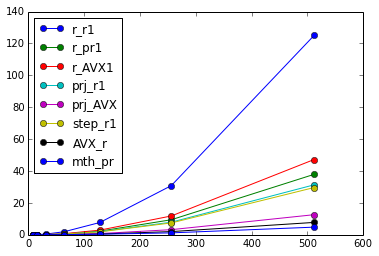

In [83]:
functions = [r_r1,r_pr1,r_AVX1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]
for k in range(len(functions)):
    plt.plot(im_sizes,times[:][k], "o-", label = "{}".format(str(functions[k])[19:-1]))
plt.legend(loc="best")

---

---

## **Benchmark when we vary the truncation parameter**

In [75]:
functions = [r_r1,r_pr1,r_AVX1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]

th = [None,2,2,2,2,2,2,2]
iters = 11
truncates = [k for k in range(1,iters)]
sigma_r = 2
sigma_s = 2
im_size = 128

assert len(functions) == len(th)

times2 = [[0 for k in truncates] for fn in functions]


for k, fn in enumerate(functions):
    print str(fn)
    for l,truncate in enumerate(truncates):
        lw = (max(sigma_r, sigma_s)*truncate)

        #create picture
        picture = np.random.random((im_size, im_size))
        
        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times2[k][l] = time_update(fn, truncate, imsize, picture, input_im, sigma_r, sigma_s, lw, th[k])
        
df2 = pd.DataFrame(times2, dtype = float)
df2.to_csv('times2.csv', index=False)

<built-in function r_r1>
<built-in function r_r1>: 1.00942111015s
<built-in function r_r1>: 2.71262311935s
<built-in function r_r1>: 4.28363919258s
<built-in function r_r1>: 7.67832303047s
<built-in function r_r1>: 10.2861511707s
<built-in function r_r1>: 15.4190070629s
<built-in function r_r1>: 18.9899201393s
<built-in function r_r1>: 25.7774009705s
<built-in function r_r1>: 30.3871181011s
<built-in function r_r1>: 39.8323748112s
<built-in function r_pr1>
<built-in function r_pr1>: 0.727787017822s
<built-in function r_pr1>: 1.25052905083s
<built-in function r_pr1>: 1.97246098518s
<built-in function r_pr1>: 2.81269001961s
<built-in function r_pr1>: 4.19944095612s
<built-in function r_pr1>: 5.64744305611s
<built-in function r_pr1>: 7.49790596962s
<built-in function r_pr1>: 9.45620512962s
<built-in function r_pr1>: 11.5738730431s
<built-in function r_pr1>: 11.4540829659s
<built-in function r_AVX1>
<built-in function r_AVX1>: 2.23056697845s
<built-in function r_AVX1>: 2.43670678139s
<buil

**Plot the results**

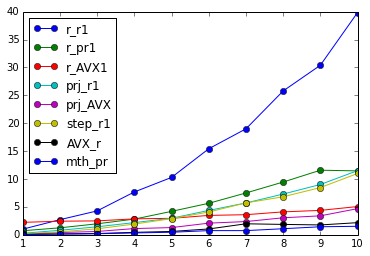

In [79]:
for k in range(len(functions)):
    plt.plot(truncates,times2[:][k],  "o-", label = "{}".format(str(functions[k])[19:-1]))
plt.legend(loc="best")

---

---

## **Benchmark when we vary the truncation parameter**

In [96]:
functions = [r_r1,r_pr1,r_AVX1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]


iters = 8
threads = [k for k in range(1,iters)]
sigma_r = 2
sigma_s = 2
im_size = 128

assert len(functions) == len(th)

times3 = [[0 for k in threads] for fn in functions]


for k, fn in enumerate(functions):
    print str(fn)
    for l,thread in enumerate(threads):
        lw = (max(sigma_r, sigma_s)*truncate)

        th = [None,thread,thread,thread,thread,thread,thread,thread]
        #create picture
        picture = np.random.random((im_size, im_size))
        
        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times3[k][l] = time_update(fn, truncate, imsize, picture, input_im, sigma_r, sigma_s, lw, th[k])
        
df2 = pd.DataFrame(times2, dtype = float)
df2.to_csv('times2.csv', index=False)

<built-in function r_r1>
<built-in function r_r1>: 26.3264899254s
<built-in function r_r1>: 26.3135619164s


KeyboardInterrupt: 

In [ ]:
for k in range(len(functions)):
    plt.plot(threads,times2[:][k],  "o-", label = "{}".format(str(functions[k])[19:-1]))
plt.legend(loc="best")